# 1. Set up

## 1.1. Install the requirements

In [1]:
! sudo apt -qq update
! sudo apt-get -qq install -y default-jdk graphviz libgraphviz-dev pkg-config python3-dev python3-pip r-base
! python3 -m pip -q install --upgrade --user networkx pronto pygraphviz pyspark rpy2 seaborn

59 packages can be upgraded. Run 'apt list --upgradable' to see them.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import gzip
import json
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
import pronto
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import arrays_zip, explode, map_keys, col
import pyspark.sql.functions as f
from scipy.stats import gaussian_kde
import seaborn as sns
from IPython import display

mpl.rcParams['figure.dpi'] = 300

# Enables the %%R magic.
%load_ext rpy2.ipython

## 1.2. Download the data
For now, we're only fetching aggregated data and metadata. We do not touch the more granular, unaggregated data. The aggregation in question is being done within all samples in a given study.

In [3]:
! mkdir -p 'aggregated_data' 'metadata'
! gsutil -q -m rsync -r 'gs://atlas_baseline_expression/rel_37_2022-02-04/aggregated_data' 'aggregated_data'
! gsutil -q -m rsync -r 'gs://atlas_baseline_expression/rel_37_2022-02-04/metadata' 'metadata'

# 2. General data structure

## 2.1. High level organisation
There are a total of 81 experiments:

In [4]:
! ls 'metadata' | wc -l

81


Each experiment has one directory which contain all its files:

In [5]:
! ls 'metadata'

E-ENAD-33     E-GEOD-46817  E-GEOD-83322  E-MTAB-3579  E-MTAB-4748  E-MTAB-6798
E-ENAD-34     E-GEOD-49906  E-GEUV-1	  E-MTAB-3708  E-MTAB-4754  E-MTAB-6811
E-ENAD-35     E-GEOD-52564  E-MTAB-1733   E-MTAB-3716  E-MTAB-4801  E-MTAB-6814
E-ENAD-41     E-GEOD-53960  E-MTAB-2262   E-MTAB-3718  E-MTAB-4840  E-MTAB-6867
E-ENAD-42     E-GEOD-55966  E-MTAB-2328   E-MTAB-3725  E-MTAB-5013  E-MTAB-7322
E-ERAD-352    E-GEOD-56796  E-MTAB-2582   E-MTAB-3819  E-MTAB-5015  E-MTAB-7391
E-ERAD-401    E-GEOD-58387  E-MTAB-2706   E-MTAB-3827  E-MTAB-5020  E-MTAB-8518
E-ERAD-499    E-GEOD-58608  E-MTAB-2770   E-MTAB-3871  E-MTAB-513   E-MTAB-8573
E-GEOD-22131  E-GEOD-63340  E-MTAB-2800   E-MTAB-3983  E-MTAB-5200  E-MTAB-8717
E-GEOD-26284  E-GEOD-68789  E-MTAB-2801   E-MTAB-4034  E-MTAB-5214  E-MTAB-9192
E-GEOD-27843  E-GEOD-70484  E-MTAB-2836   E-MTAB-4101  E-MTAB-5423  E-MTAB-9372
E-GEOD-31234  E-GEOD-72095  E-MTAB-3079   E-MTAB-4344  E-MTAB-5782
E-GEOD-43717  E-GEOD-73175  E-MTAB-3358   E-MTAB-4644  E

For each experiment we have two files for FPKM and TPM values, as well as a single metadata JSON, contained in a separate directory:

In [6]:
! tree 'aggregated_data' | head -n 10

aggregated_data
├── E-ENAD-33
│   ├── E-ENAD-33-expression-data-fpkms.jsonl.bz2
│   └── E-ENAD-33-expression-data-tpms.jsonl.bz2
├── E-ENAD-34
│   ├── E-ENAD-34-expression-data-fpkms.jsonl.bz2
│   └── E-ENAD-34-expression-data-tpms.jsonl.bz2
├── E-ENAD-35
│   ├── E-ENAD-35-expression-data-fpkms.jsonl.bz2
│   └── E-ENAD-35-expression-data-tpms.jsonl.bz2


In [7]:
! tree 'metadata' | head -n 7

metadata
├── E-ENAD-33
│   └── E-ENAD-33.metadata.json
├── E-ENAD-34
│   └── E-ENAD-34.metadata.json
├── E-ENAD-35
│   └── E-ENAD-35.metadata.json


## 2.2. Structure of data and metadata and links between them
Each experiment consists of a small amount of general metadata and a large number of `experimentalDesigns` entries. The data contains min/quartiles/max expression values, and is linked back to metadata via the `assayGroupId` field:

In [8]:
! jq <'metadata/E-MTAB-5214/E-MTAB-5214.metadata.json' 2>/dev/null | head -n 36

{
  "experimentId": "E-MTAB-5214",
  "experimentType": "rnaseq_mrna_baseline",
  "species": "Homo sapiens",
  "pubmedIds": [
    "25954001"
  ],
  "provider": "; The GTEx Consortium",
  "experimentalDesigns": [
    {
      "assayGroupId": "g1",
      "assayId": "SRR817658",
      "assayGroup": "Brodmann (1909) area 24",
      "disease": "normal",
      "individual": "GTEX-X4EP",
      "organismPart": "Brodmann (1909) area 24",
      "sex": "female"
    },
    {
      "assayGroupId": "g1",
      "assayId": "SRR2135337",
      "assayGroup": "Brodmann (1909) area 24",
      "disease": "normal",
      "individual": "GTEX-T6MN",
      "organismPart": "Brodmann (1909) area 24",
      "sex": "male"
    },
    {
      "assayGroupId": "g1",
      "assayId": "SRR817832",
      "assayGroup": "Brodmann (1909) area 24",
      "disease": "normal",
      "individual": "GTEX-WHSE",
      "organismPart": "Brodmann (1909) area 24",
      "sex": "male"
    },


In [9]:
! bzip2 -d <'aggregated_data/E-MTAB-5214/E-MTAB-5214-expression-data-tpms.jsonl.bz2' | jq 2>/dev/null | head -n 27

{
  "geneProductId": "ENSG00000000003",
  "expression": [
    {
      "assayGroupId": "g1",
      "min": 0,
      "q1": 4,
      "q2": 6,
      "q3": 8,
      "max": 17
    },
    {
      "assayGroupId": "g10",
      "min": 0,
      "q1": 28,
      "q2": 36,
      "q3": 44,
      "max": 126
    },
    {
      "assayGroupId": "g11",
      "min": 0,
      "q1": 5,
      "q2": 7,
      "q3": 10,
      "max": 23
    },


# 3. Tissue representation and hierarchy

Inside the metadata, tissue information is represented by two fields: `organismPart`, such as "liver", and `organismPartOntURI`, such as http://purl.obolibrary.org/obo/UBERON_0002107.

## 3.1. Total count and list of tissues by (name + ontology) pair

In [10]:
%%bash
cat <<'EOF' >bash_functions.sh
#!/bin/bash
extract_tissues () {
  # Not extracting cell types for now
  jq --raw-output '. as $experiment | .experimentalDesigns | .[] | $experiment.experimentId + "|" + .assayGroupId + "|" + .organismPart + "|" + .organismPartOntURI' <"$1" \
  | sort -u
}
process_tissues () {
  cut -d'|' -f3,4 \
  | sort \
  | uniq -c \
  | sort -k1,1rn \
  | sed -e 's/^ *//' -e 's/ /|/' \
  | tr '|' '\t'
}
export -f extract_tissues process_tissues
EOF

In [11]:
%%bash
. bash_functions.sh
parallel extract_tissues ::: metadata/*/*.json | process_tissues >'tissues.tsv'

In [12]:
def read_df(filename):
    return pd.read_table(filename, names=('count', 'organismPart', 'organismPartOntURI'))
    
df = read_df('tissues.tsv')
with pd.option_context('display.max_rows', 500):
    display.display(df)

,count,organismPart,organismPartOntURI
0,1015,whole organism,http://purl.obolibrary.org/obo/UBERON_0000468
1,844,blood,http://purl.obolibrary.org/obo/UBERON_0000178
2,482,lung,http://purl.obolibrary.org/obo/UBERON_0002048
3,456,skin,http://purl.obolibrary.org/obo/UBERON_0000014
4,349,liver,http://purl.obolibrary.org/obo/UBERON_0002107
5,336,kidney,http://purl.obolibrary.org/obo/UBERON_0002113
6,329,NaN,NaN
7,242,ovary,http://purl.obolibrary.org/obo/UBERON_0000992
8,215,breast,http://purl.obolibrary.org/obo/UBERON_0000310
9,173,hematopoietic system and lymphoid system,NaN


There is a total of 290 distinct tissue records. Some data issues are apparent:
1. 329 assays have no tissue information at all
1. Some records don't have a tissue URI despite having exactly the same name, for example: 482 "lung" records have a URI while 64 do not.

However, mostly the tissue annotation is of quite decent quality.

## 3.2. Total count and list of tissues by name only
Because of the missing ontology URIs, some entries above are effectively duplicated. Let's drop the URI and see how many unique tissue *names* are really there.

In [13]:
def aggregate_df(df):
    return (
        df
        .drop('organismPartOntURI', axis=1)
        .groupby(by=['organismPart'])
        .sum()
        .sort_values(by='count', ascending=False)
        .reset_index()
    )

df_agg = aggregate_df(df)
with pd.option_context('display.max_rows', 500):
    display.display(df_agg)

,organismPart,count
0,whole organism,1015
1,blood,845
2,lung,546
3,skin,483
4,kidney,355
5,liver,353
6,ovary,257
7,breast,227
8,hematopoietic system and lymphoid system,173
9,pancreas,167


With this, we get 235 distinct non-empty records.

# 4. Focus on GTEx
The GTEx experiment is [E-MTAB-5214](https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-5214). It is large and internally consistent, and does not require batch correction, so is useful for investigation during the early stage.

## 4.1. List of tissues

In [14]:
%%bash
. bash_functions.sh
extract_tissues metadata/E-MTAB-5214/E-MTAB-5214.metadata.json | process_tissues >'tissues_gtex.tsv'

In [15]:
df = read_df('tissues_gtex.tsv')
with pd.option_context('display.max_rows', 500):
    display.display(df)

,count,organismPart,organismPartOntURI
0,1,Brodmann (1909) area 24,NaN
1,1,Brodmann (1909) area 9,NaN
2,1,C1 segment of cervical spinal cord,NaN
3,1,EBV-transformed lymphocyte,NaN
4,1,adrenal gland,NaN
5,1,amygdala,NaN
6,1,aorta,NaN
7,1,atrium auricular region,NaN
8,1,blood,NaN
9,1,breast,NaN


None of the records contain ontology links. However, all of them appear to come from UBERON, and there is only one aggregated assay per tissue. There is a total of 53 tissues. GTEx also only contains human data, and indeed there is no cell type information present at all.

## 4.2. Example nesting for one tissue

In [16]:
warnings.simplefilter('ignore', pronto.warnings.ProntoWarning)
uberon = pronto.Ontology('http://purl.obolibrary.org/obo/uberon/ext.owl')

DiGraph with 17 nodes and 25 edges


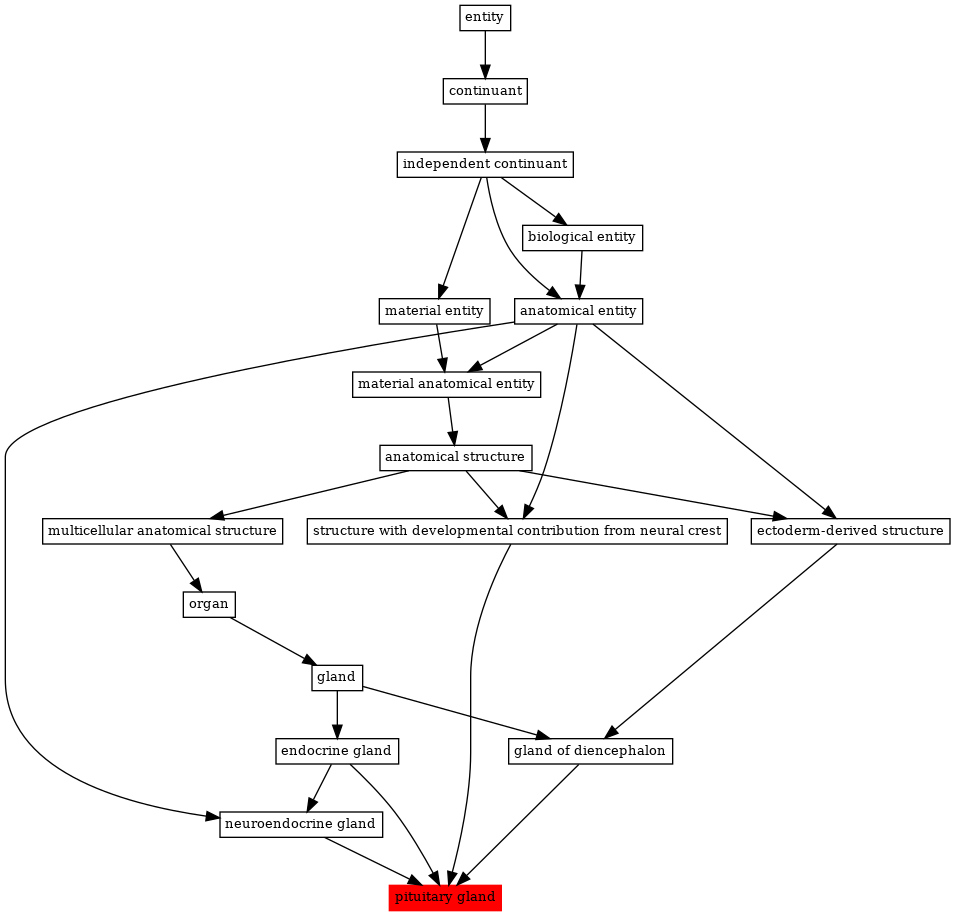

In [17]:
def add_all_parents_to_graph(G, term):
    for superclass in term.superclasses(distance=1, with_self=False):
        if not superclass.name:
            continue
        G.add_node(superclass.name, shape='rectangle')
        G.add_edge(superclass.name, term.name)
        G = add_all_parents_to_graph(G, superclass)
    return G

def process_terms_of_interest(terms_of_interest):
    G = nx.DiGraph()
    for term in uberon.terms():
        if term.name in terms_of_interest:
            G.add_node(term.name, color='red', style='filled', shape='rectangle')
            G = add_all_parents_to_graph(G, term)
    return G
            
G = process_terms_of_interest({'pituitary gland'})
print(G)
nx.nx_agraph.write_dot(G,'graph_one.dot')
! dot -Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0.05 -Tpng graph_one.dot >graph_one.png
display.Image("graph_one.png")

## 4.3. Nesting for all GTEx tissues

DiGraph with 189 nodes and 283 edges


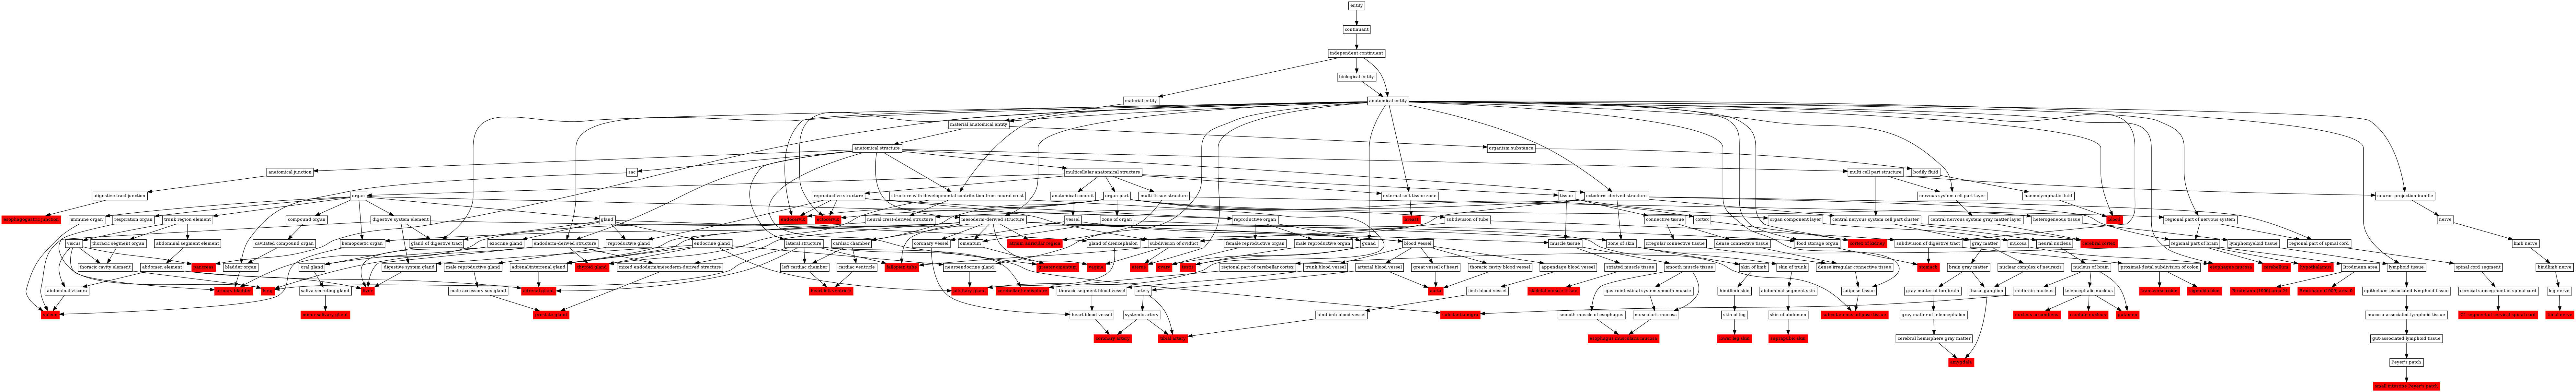

In [18]:
G = process_terms_of_interest(set(df['organismPart']))
print(G)
nx.nx_agraph.write_dot(G,'graph.dot')
! dot -Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0.05 -Tpng graph.dot >graph.png
display.Image("graph.png")

# 5. Process expression data

In [19]:
# Initialise Spark session
sparkConf = (
    SparkConf()
    .set('spark.driver.memory', '60g')
    .set('spark.executor.memory', '60g')
    .set('spark.driver.maxResultSize', '0')
    .set('spark.debug.maxToStringFields', '2000')
    .set('spark.sql.execution.arrow.maxRecordsPerBatch', '500000')
)
spark = SparkSession.builder.config(conf=sparkConf).master('local[*]').getOrCreate()

In [20]:
# Read the dataframe
df = spark.read.json('aggregated_data/E-MTAB-5214/E-MTAB-5214-expression-data-fpkms.jsonl.bz2')

In [21]:
# Examine the dataframe and its schema
df.printSchema()
df.show()

root
 |-- expression: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- assayGroupId: string (nullable = true)
 |    |    |-- max: double (nullable = true)
 |    |    |-- min: double (nullable = true)
 |    |    |-- q1: double (nullable = true)
 |    |    |-- q2: double (nullable = true)
 |    |    |-- q3: double (nullable = true)
 |-- geneProductId: string (nullable = true)
 |-- unit: string (nullable = true)

+--------------------+---------------+-----+
|          expression|  geneProductId| unit|
+--------------------+---------------+-----+
|[{g1, 7.0, 0.0, 2...|ENSG00000000003|fpkms|
|[{g1, 0.3, 0.0, 0...|ENSG00000000005|fpkms|
|[{g1, 39.0, 0.0, ...|ENSG00000000419|fpkms|
|[{g1, 2.0, 0.0, 0...|ENSG00000000457|fpkms|
|[{g1, 0.5, 0.0, 0...|ENSG00000000460|fpkms|
|[{g1, 24.0, 0.0, ...|ENSG00000000938|fpkms|
|[{g1, 14.0, 0.0, ...|ENSG00000000971|fpkms|
|[{g1, 11.0, 0.0, ...|ENSG00000001036|fpkms|
|[{g1, 10.0, 0.0, ...|ENSG00000001084|fpkms|
|[{g1, 1

Each observation includes min/q1/q2/q3/max values, but for now we're only using q2.

In [22]:
# Extract just the values we need: gene, assay, median expression
df_expl = (
    df
    .withColumn('expression_expl', explode('expression'))
    .select('geneProductId', 'expression_expl.assayGroupId', 'expression_expl.q2')
)
df_expl.show()

+---------------+------------+----+
|  geneProductId|assayGroupId|  q2|
+---------------+------------+----+
|ENSG00000000003|          g1| 3.0|
|ENSG00000000003|         g10|12.0|
|ENSG00000000003|         g11| 4.0|
|ENSG00000000003|         g12| 0.6|
|ENSG00000000003|         g13| 0.9|
|ENSG00000000003|         g14| 2.0|
|ENSG00000000003|         g15| 3.0|
|ENSG00000000003|         g16| 7.0|
|ENSG00000000003|         g17|11.0|
|ENSG00000000003|         g18|13.0|
|ENSG00000000003|         g19| 3.0|
|ENSG00000000003|          g2| 2.0|
|ENSG00000000003|         g20|13.0|
|ENSG00000000003|         g21| 3.0|
|ENSG00000000003|         g22| 9.0|
|ENSG00000000003|         g23|10.0|
|ENSG00000000003|         g24| 1.0|
|ENSG00000000003|         g25| 3.0|
|ENSG00000000003|         g26| 4.0|
|ENSG00000000003|         g27|11.0|
+---------------+------------+----+
only showing top 20 rows



In [23]:
# Aggregate into a single expression map per gene
# As per https://stackoverflow.com/a/58708077
df_agg = (
    df_expl
    .groupby('geneProductId')
    .agg(
        f.map_from_entries(
            f.collect_list(
                f.struct('assayGroupId', 'q2')
            )
        ).alias('expr_map')
    )
)
df_agg.show()

+---------------+--------------------+
|  geneProductId|            expr_map|
+---------------+--------------------+
|ENSG00000001561|{g1 -> 6.0, g10 -...|
|ENSG00000004142|{g1 -> 34.0, g10 ...|
|ENSG00000004766|{g1 -> 3.0, g10 -...|
|ENSG00000004948|{g1 -> 0.0, g10 -...|
|ENSG00000005073|{g1 -> 0.0, g10 -...|
|ENSG00000005486|{g1 -> 83.0, g10 ...|
|ENSG00000005884|{g1 -> 3.0, g10 -...|
|ENSG00000006015|{g1 -> 13.0, g10 ...|
|ENSG00000006071|{g1 -> 7.0, g10 -...|
|ENSG00000006194|{g10 -> 5.0, g11 ...|
|ENSG00000006638|{g1 -> 0.5, g10 -...|
|ENSG00000007062|{g1 -> 0.9, g10 -...|
|ENSG00000007341|{g1 -> 0.6, g10 -...|
|ENSG00000007520|{g1 -> 25.0, g10 ...|
|ENSG00000008130|{g1 -> 7.0, g10 -...|
|ENSG00000008282|{g1 -> 9.0, g10 -...|
|ENSG00000008853|{g1 -> 12.0, g10 ...|
|ENSG00000009830|{g1 -> 2.0, g10 -...|
|ENSG00000010319|{g1 -> 3.0, g10 -...|
|ENSG00000010404|{g1 -> 175.0, g10...|
+---------------+--------------------+
only showing top 20 rows



In [24]:
# Calculate the list of unique assay group IDs
distinct_assay_groups = sorted(
    [a.assayGroupId for a in df_expl.select('assayGroupId').distinct().collect()]
)
print(distinct_assay_groups)

['g1', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18', 'g19', 'g2', 'g20', 'g21', 'g22', 'g23', 'g24', 'g25', 'g26', 'g27', 'g28', 'g29', 'g3', 'g30', 'g31', 'g32', 'g33', 'g34', 'g35', 'g36', 'g37', 'g38', 'g39', 'g4', 'g40', 'g41', 'g42', 'g43', 'g44', 'g45', 'g46', 'g47', 'g48', 'g49', 'g5', 'g50', 'g51', 'g52', 'g53', 'g6', 'g7', 'g8', 'g9']


In [25]:
# Convert expression values into separate columns
# As per https://sparkbyexamples.com/pyspark/pyspark-convert-dictionary-map-to-multiple-columns/
key_cols = [
    f.col('expr_map').getItem(x).alias(str(x))
    for x in distinct_assay_groups
]
df_expr = df_agg.select('geneProductId', *key_cols)

In [26]:
# Extract everything into Pandas
d = df_expr.toPandas()
d.set_index('geneProductId', inplace=True)
display.display(d)

,g1,g10,g11,g12,g13,g14,g15,g16,g17,g18,...,g49,g5,g50,g51,g52,g53,g6,g7,g8,g9
geneProductId,,,,,,,,,,,,,,,,,,,,,
ENSG00000001561,6.0,6.0,6.0,5.0,5.0,5.0,11.0,4.0,2.0,4.0,...,1.0,4.0,5.0,4.0,2.0,1.0,5.0,9.0,6.0,0.9
ENSG00000004142,34.0,37.0,27.0,32.0,35.0,41.0,34.0,57.0,33.0,31.0,...,45.0,92.0,36.0,31.0,32.0,34.0,25.0,32.0,43.0,16.0
ENSG00000004766,3.0,3.0,2.0,5.0,5.0,3.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,0.5
ENSG00000004948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000005073,0.0,0.2,0.0,0.0,0.0,0.0,0.0,1.0,17.0,28.0,...,6.0,0.3,6.0,9.0,40.0,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000281877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000281885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Finally, filter out genes with exactly zero expression across tissues
nonzero_mask = ~np.all(d == 0, axis=1)
display.display(d[nonzero_mask])

,g1,g10,g11,g12,g13,g14,g15,g16,g17,g18,...,g49,g5,g50,g51,g52,g53,g6,g7,g8,g9
geneProductId,,,,,,,,,,,,,,,,,,,,,
ENSG00000001561,6.0,6.0,6.0,5.0,5.0,5.0,11.0,4.0,2.0,4.0,...,1.0,4.0,5.0,4.0,2.0,1.0,5.0,9.0,6.0,0.9
ENSG00000004142,34.0,37.0,27.0,32.0,35.0,41.0,34.0,57.0,33.0,31.0,...,45.0,92.0,36.0,31.0,32.0,34.0,25.0,32.0,43.0,16.0
ENSG00000004766,3.0,3.0,2.0,5.0,5.0,3.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,0.5
ENSG00000004948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000005073,0.0,0.2,0.0,0.0,0.0,0.0,0.0,1.0,17.0,28.0,...,6.0,0.3,6.0,9.0,40.0,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281523,1.0,0.0,0.7,11.0,13.0,2.0,0.0,0.2,0.4,1.0,...,0.0,0.0,0.0,0.0,3.0,0.3,0.9,0.0,0.0,0.0
ENSG00000281531,1.0,1.0,0.9,2.0,2.0,1.0,0.8,0.8,2.0,1.0,...,0.7,0.8,0.9,1.0,1.0,1.0,0.8,0.9,0.6,0.5
ENSG00000281548,0.2,0.4,0.2,0.4,0.4,0.2,0.2,0.2,0.3,0.4,...,0.3,0.3,0.3,0.2,0.3,0.3,0.2,0.2,0.2,0.2


# 6. Interlude: Gini coefficient

[Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient) is a metric in economics which is used to characterise inequality in income, net worth, or other metrics. It ranges from 0 (perfect equality) to 1 (maximum inequality). So I thought it would be interesting to apply it for this problem.

In [28]:
# Adapted from https://github.com/oliviaguest/gini/blob/master/gini.py
def gini(row):
    """Calculate the Gini coefficient of a Pandas row."""
    assert min(row) >= 0
    if max(row) == 0:
        return np.nan
    # # Values cannot be 0:  (disabled because zeroes are filtered out already)
    # array += 0.0000001
    # Values must be sorted:
    array = np.sort(row)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [29]:
# a is going to be our annotations array
a = d.iloc[:,:0].copy()
a['gini'] = d.apply(gini, axis=1)
display.display(a)

,gini
geneProductId,
ENSG00000001561,0.298787
ENSG00000004142,0.173798
ENSG00000004766,0.169161
ENSG00000004948,0.947048
ENSG00000005073,0.860977
...,...
ENSG00000281870,NaN
ENSG00000281877,NaN
ENSG00000281885,NaN


Now, initially, when we plot a histogram of Gini coefficient values for all genes, it looks like there is a right tail of highly specifically expressed genes:

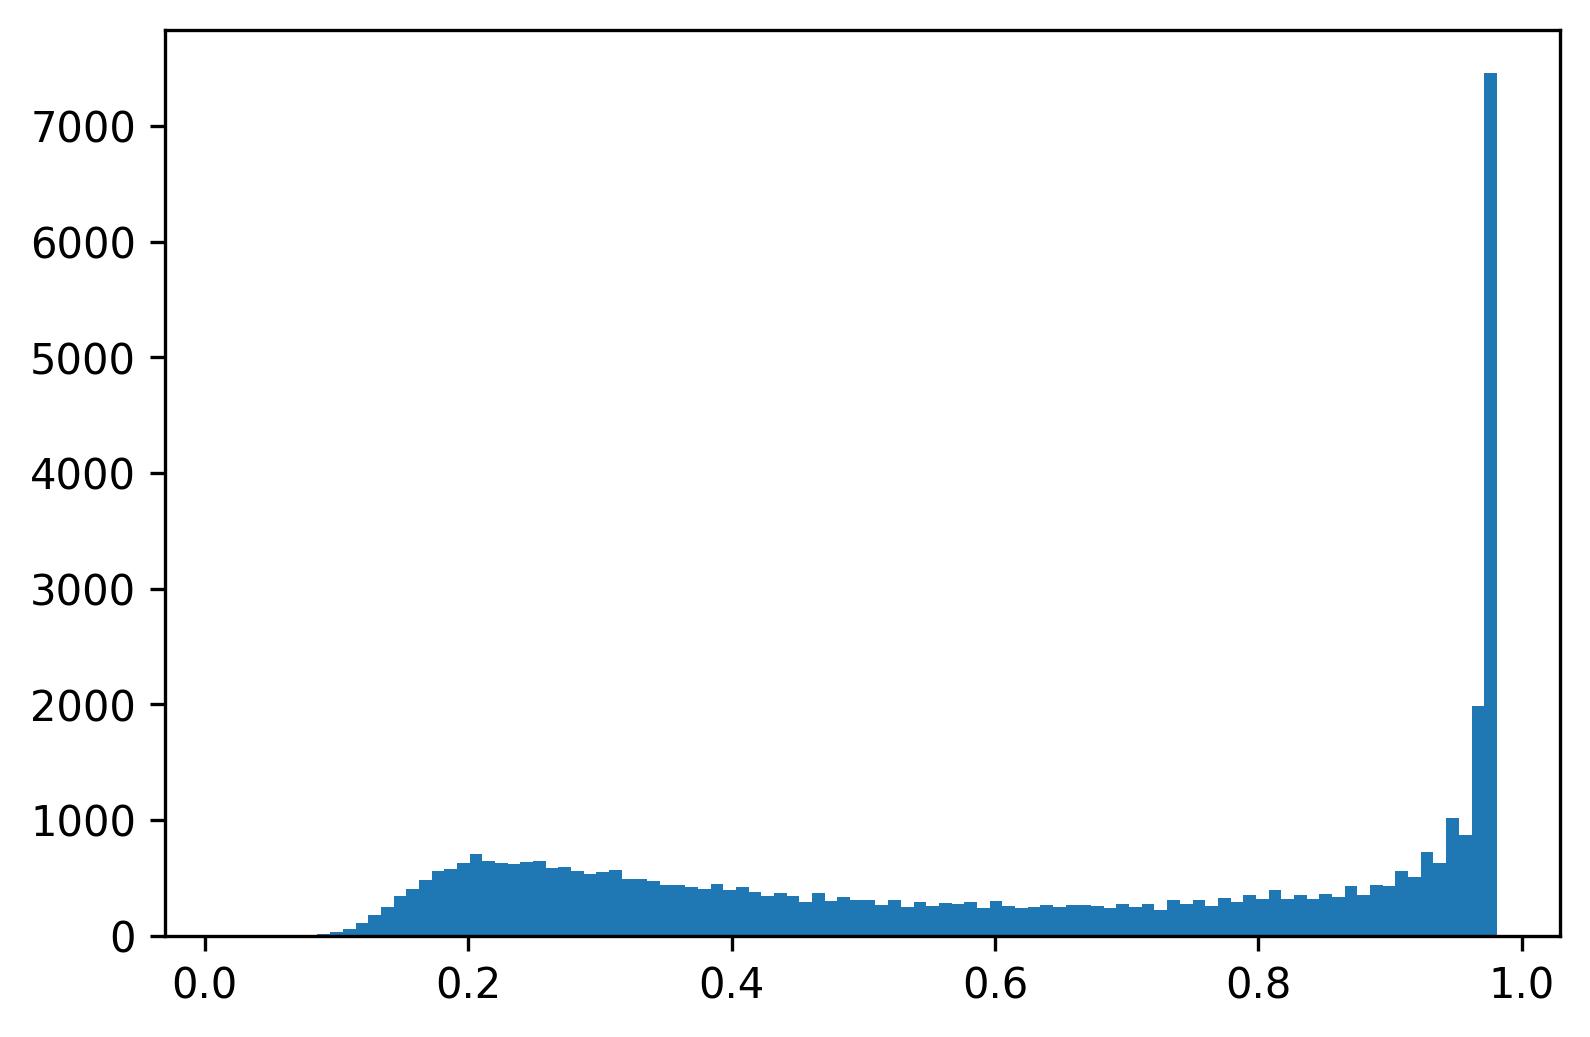

In [30]:
plt.hist(a.gini, bins=100)
plt.show()

However, what's actually happening is that many genes have very low total expression: nearly zero, but not _precisely_ zero, hence they weren't filtered out by the previous step. Such genes will often produce very high Gini coefficients by chance.

To check that, we can plot their Gini coefficients versus their total coverage, to see if there is a trend, and to learn how to filter out such genes.

## 6.1. Looking at Gini coefficients vs. total expression

In [31]:
def gini_vs_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=2)
    ax.set_xlabel('log10 of total gene expression across all tissues')
    ax.set_ylabel('Gini coefficient of gene expression')
    plt.show()

/home/ktsukanov/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 1800x1200 with 0 Axes>

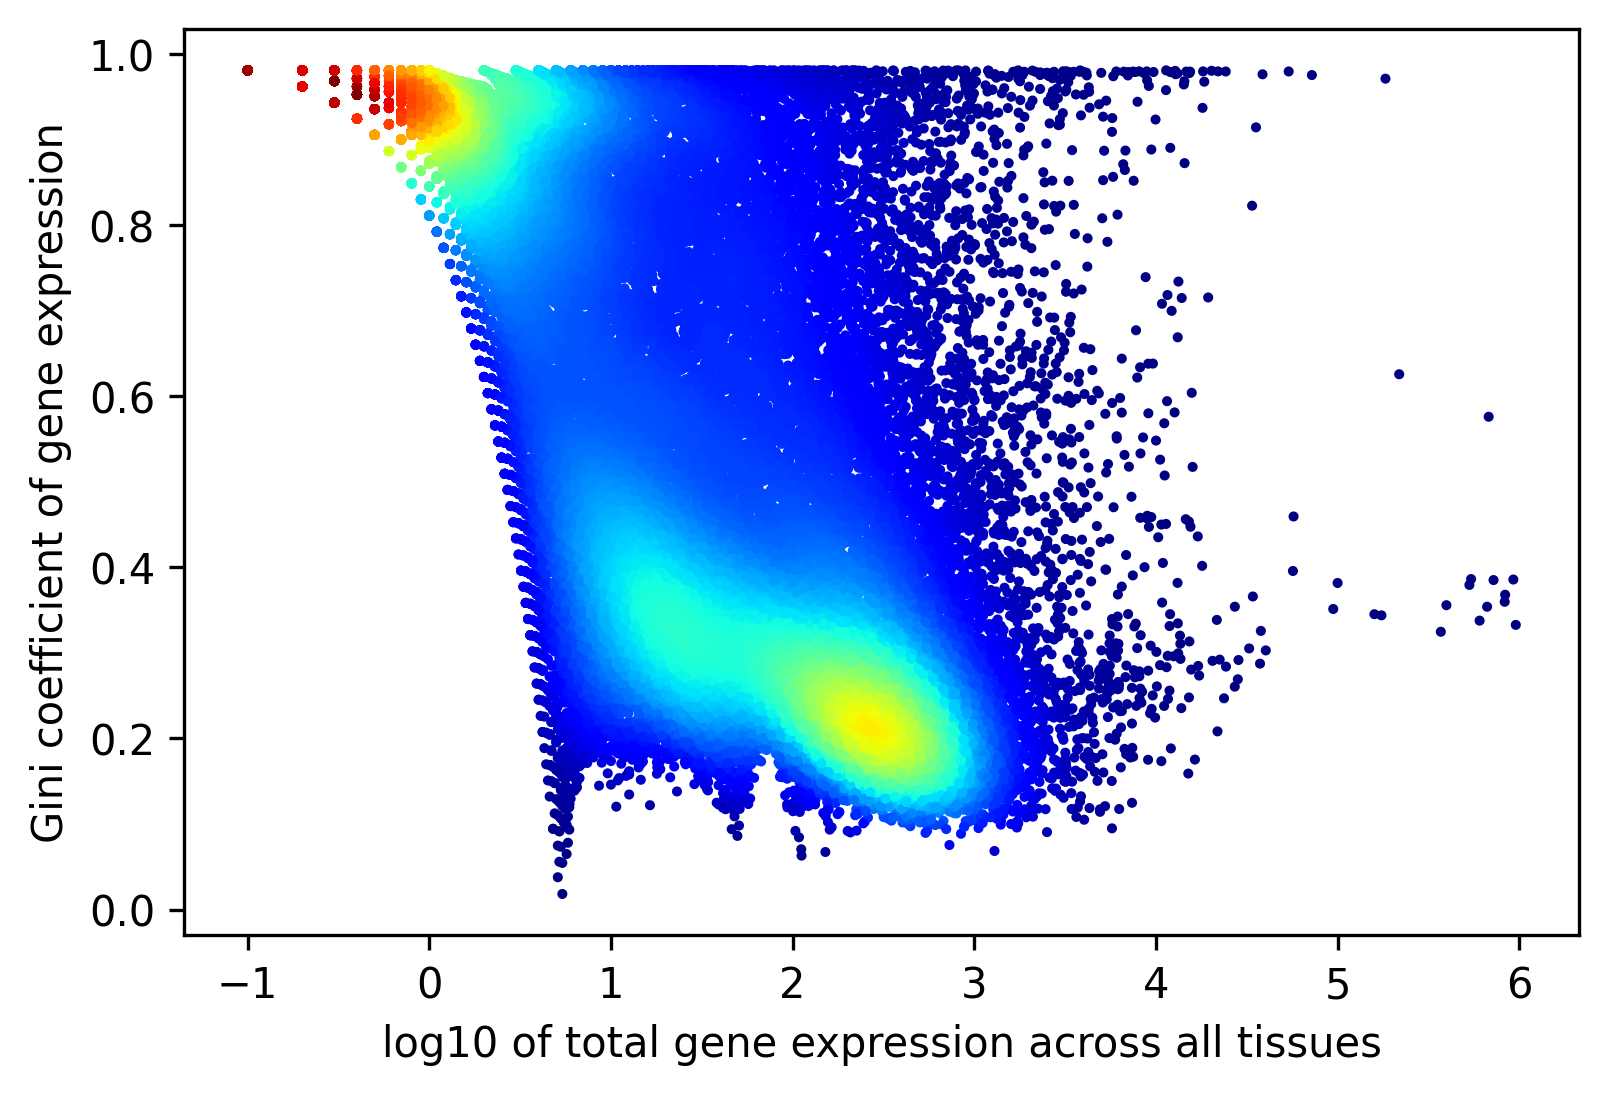

In [32]:
a['total_expr'] = d.sum(axis=1)
a['total_expr_log'] = np.log10(a.total_expr)
gini_vs_expression(a.total_expr_log[nonzero_mask], a.gini[nonzero_mask])

A natural threshold for filtering seems to be around log10 of total expression around **1** (that is, the total absolute value of 10). Let's apply it and see how the picture changes.

## 6.2. Filter out everything with total expression less than threshold

After we filter out all genes with very low expression, this is the picture we get:

<Figure size 1800x1200 with 0 Axes>

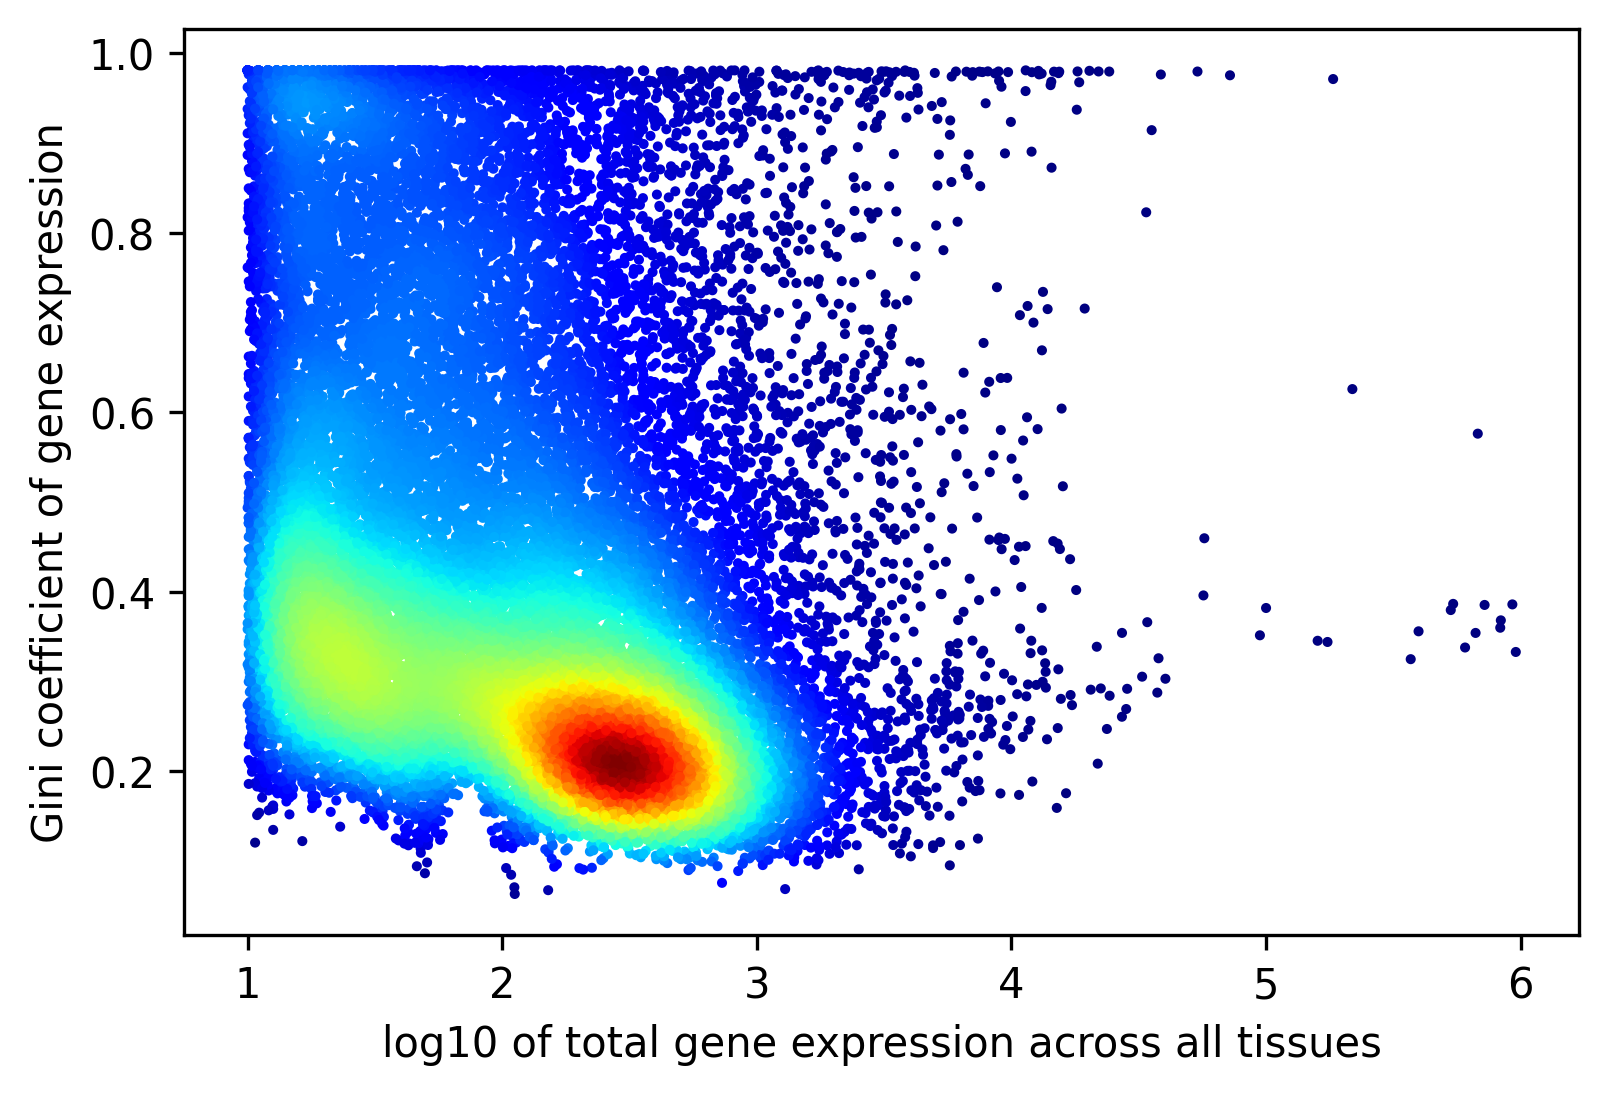

In [33]:
THRESHOLD = 1

total_expr_mask = a.total_expr_log >= THRESHOLD
gini_vs_expression(a.total_expr_log[total_expr_mask], a.gini[total_expr_mask])

 It seems sensible to define three categories with roughly these thresholds:
* 0.95 < G: Highly specifically expressed
* 0.50 < G < 0.95: Moderately specifically expressed
* G < 0.50: Not specifically expressed

The total counts in each category would be:

In [34]:
print(sum(0.95 < a.gini[total_expr_mask]))
print(sum((0.50 <= a.gini[total_expr_mask]) & (a.gini[total_expr_mask] <= 0.95)))
print(sum(a.gini[total_expr_mask] < 0.50))

1061
7414
16334


Finally, after filtering, let's look at the histogram of Gini coefficient values:

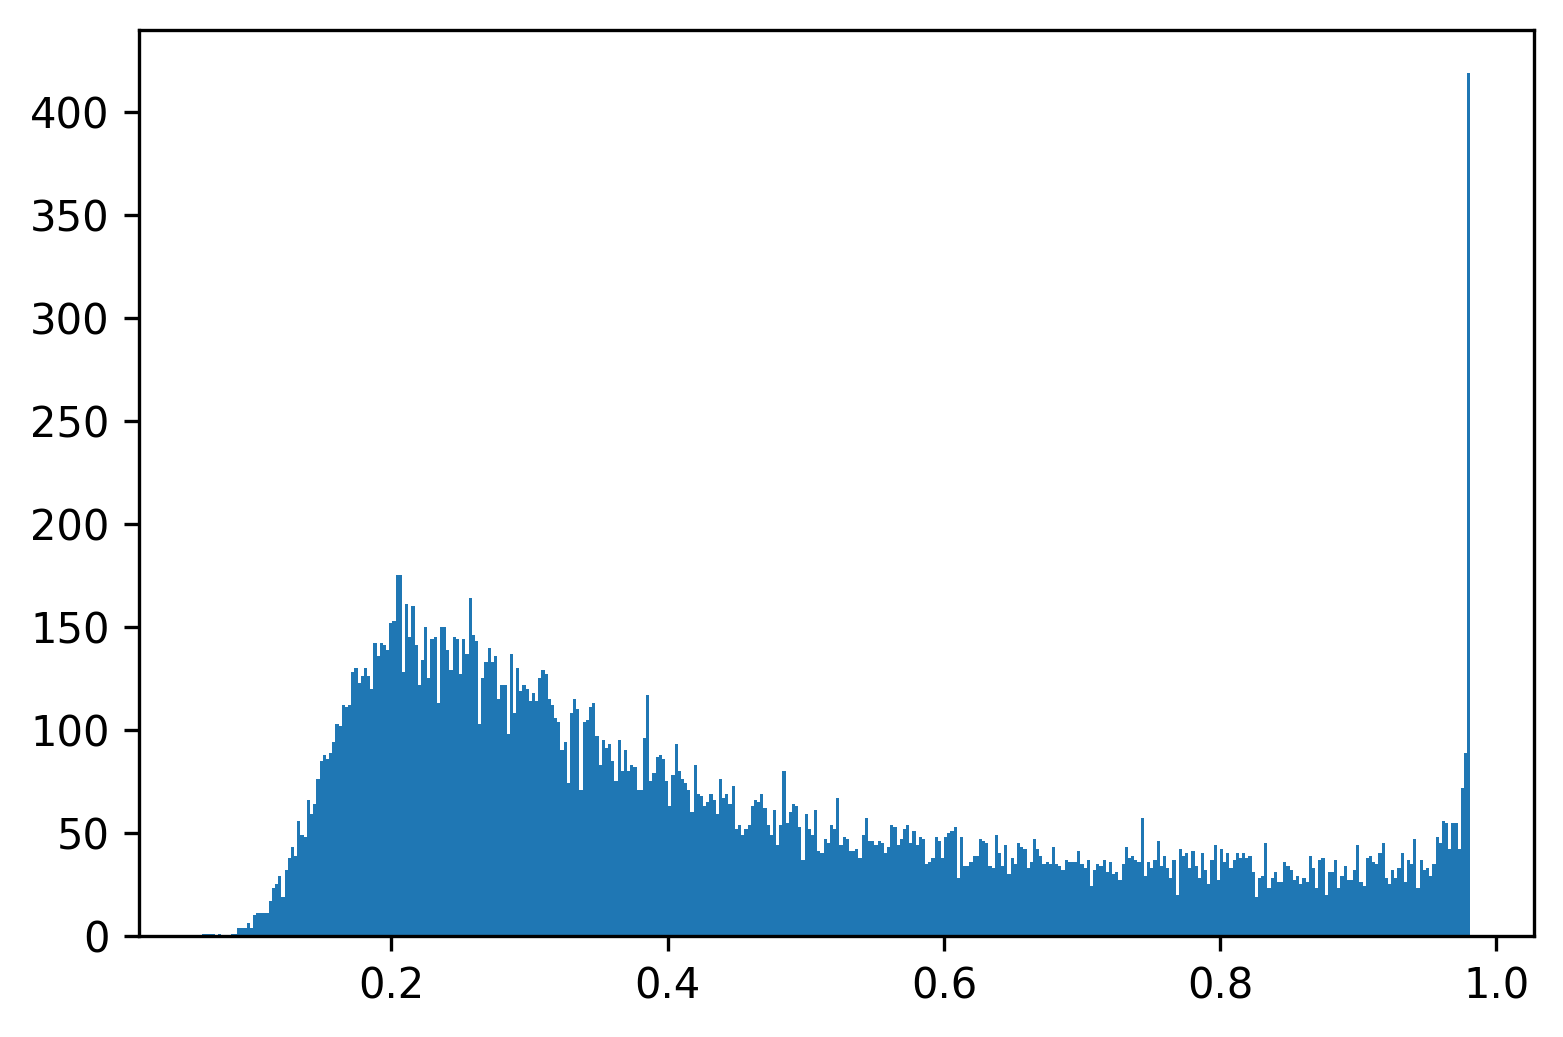

In [35]:
plt.hist(a.gini[total_expr_mask], bins=400)
plt.show()

# 7. Comparison with HPA

## 7.1. HPA categories and noise threshold

HPA definitions of the tissue expression categories are available on this page: https://www.proteinatlas.org/about/assays+annotation#classification_rna

There are two dimensions: **specificity** and **distribution.**

By coincidence, they use exactly the same threshold (nTPM > 1) for filtering out noise as I did in my previous investigations. Their definitions appear to be sensible, however, quite arbitrary, which is obvious from their use of cut-offs such as "a third" or "four times".

## 7.2. HPA specificity definitions

| Category        | Description                                                                                                                                                                                |
|:----------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Enriched        | nTPM in a particular tissue/region/cell type at least four times any other tissue/region/cell type                                                                                         |
| Group enriched  | nTPM in a group (of 2-5 tissues, brain regions, single cell types or cell lines, or 2-10 blood cell types) at least four times any other tissue/region/cell line/blood cell type/cell type |
| Enhanced        | nTPM in a one or several (1-5 tissues, brain regions or cell lines, or 1-10 immune cell types or single cell types) at least four times the mean of other tissue/region/cell types         |
| Low specificity | nTPM ≥ 1 in at least one tissue/region/cell type but not elevated in any tissue/region/cell type                                                                                           |
| Not detected    | nTPM < 1 in all tissue/region/cell types                                                                                                                                                   |

## 7.3. HPA distribution definitions
| Category           | Description                                                                     |
|:-------------------|:--------------------------------------------------------------------------------|
| Detected in single | Detected in a single tissue/region/cell type                                    |
| Detected in some   | Detected in more than one but less than one third of tissues/regions/cell types |
| Detected in many   | Detected in at least a third but not all tissues/regions/cell types             |
| Detected in all    | Detected in all tissues/regions/cell types                                      |
| Not detected       | nTPM < 1 in all tissues/regions/cell types                                      |

## 7.4. Recompute HPA values

To validate the whole pipeline so far, let's recompute the HPA values for our data; essentially, reproduce their results.

First, a quick reminder of the data we're working with. We have two primary Pandas dataframes: `d`, which is all the expression data; and `a`, which will contain the gene-wise annotation columns. This way, we can both worh with summary metrics, and do tissue-wise calculations and comparisons.

In [36]:
THRESHOLD = 1.0

def hpa_specificity(row):
    expr = sorted(row)
    if expr[-1] < THRESHOLD:
        return 'Not detected'
    if expr[-2] == 0 or expr[-1]/expr[-2] >= 4.0:
        return 'Tissue enriched'
    for i in range(2, 6):
        if expr[-i-1] == 0 or expr[-i] / expr[-i-1] >= 4.0:
            return 'Group enriched'
    mean = sum(expr) / len(row)
    if 1 <= sum([e / mean >= 4.0 for e in expr]) <= 5:
        return 'Tissue enhanced'
    return 'Low tissue specificity'

def hpa_distribution(row):
    expr = sorted(row)
    if expr[-1] < THRESHOLD:
        return 'Not detected'
    num_detected = sum([e > THRESHOLD for e in expr])
    if num_detected == 1:
        return 'Detected in single'
    if num_detected < len(row) / 3:
        return 'Detected in some'
    if num_detected < len(row):
        return 'Detected in many'
    return 'Detected in all'

a['hpa_specificity'] = d.apply(hpa_specificity, axis=1)
a['hpa_distribution'] = d.apply(hpa_distribution, axis=1)
display.display(a)

,gini,total_expr,total_expr_log,hpa_specificity,hpa_distribution
geneProductId,,,,,
ENSG00000001561,0.298787,295.8,2.470998,Low tissue specificity,Detected in many
ENSG00000004142,0.173798,2016.0,3.304491,Low tissue specificity,Detected in all
ENSG00000004766,0.169161,130.5,2.115611,Low tissue specificity,Detected in many
ENSG00000004948,0.947048,3.1,0.491362,Tissue enriched,Detected in single
ENSG00000005073,0.860977,147.2,2.167908,Tissue enhanced,Detected in some
...,...,...,...,...,...
ENSG00000281870,NaN,0.0,-inf,Not detected,Not detected
ENSG00000281877,NaN,0.0,-inf,Not detected,Not detected
ENSG00000281885,NaN,0.0,-inf,Not detected,Not detected


## 7.5. Compare HPA results with mine

In [37]:
! wget -qOproteinatlas.json.gz https://www.proteinatlas.org/download/proteinatlas.json.gz

In [38]:
hpa = spark.read.json('proteinatlas.json.gz')
hpa_s = hpa.select([
    'Ensembl',
    'RNA tissue specificity',
    'RNA tissue distribution'
]).toPandas()

In [39]:
hpa_s.set_index('Ensembl', inplace=True)
display.display(hpa_s)

,RNA tissue specificity,RNA tissue distribution
Ensembl,,
ENSG00000000003,Low tissue specificity,Detected in many
ENSG00000000005,Tissue enhanced,Detected in some
ENSG00000000419,Low tissue specificity,Detected in all
ENSG00000000457,Low tissue specificity,Detected in all
ENSG00000000460,Tissue enhanced,Detected in many
...,...,...
ENSG00000288677,Tissue enhanced,Detected in some
ENSG00000288678,Not detected,Not detected
ENSG00000288681,Tissue enriched,Detected in single


In [40]:
a_merged = pd.merge(a, hpa_s, left_index=True, right_index=True)
display.display(a_merged)

,gini,total_expr,total_expr_log,hpa_specificity,hpa_distribution,RNA tissue specificity,RNA tissue distribution
ENSG00000001561,0.298787,295.8,2.470998,Low tissue specificity,Detected in many,Low tissue specificity,Detected in all
ENSG00000004142,0.173798,2016.0,3.304491,Low tissue specificity,Detected in all,Low tissue specificity,Detected in all
ENSG00000004766,0.169161,130.5,2.115611,Low tissue specificity,Detected in many,Low tissue specificity,Detected in all
ENSG00000004948,0.947048,3.1,0.491362,Tissue enriched,Detected in single,Tissue enhanced,Detected in some
ENSG00000005073,0.860977,147.2,2.167908,Tissue enhanced,Detected in some,Tissue enhanced,Detected in many
...,...,...,...,...,...,...,...
ENSG00000278198,NaN,0.0,-inf,Not detected,Not detected,Not detected,Not detected
ENSG00000278619,0.189897,155.0,2.190332,Low tissue specificity,Detected in many,Low tissue specificity,Detected in many
ENSG00000278845,0.167007,646.0,2.810233,Low tissue specificity,Detected in all,Low tissue specificity,Detected in many
ENSG00000278848,NaN,0.0,-inf,Not detected,Not detected,Group enriched,Detected in some


### 7.5.1. Specificity similarity matrix

<AxesSubplot:xlabel='RNA tissue specificity', ylabel='hpa_specificity'>

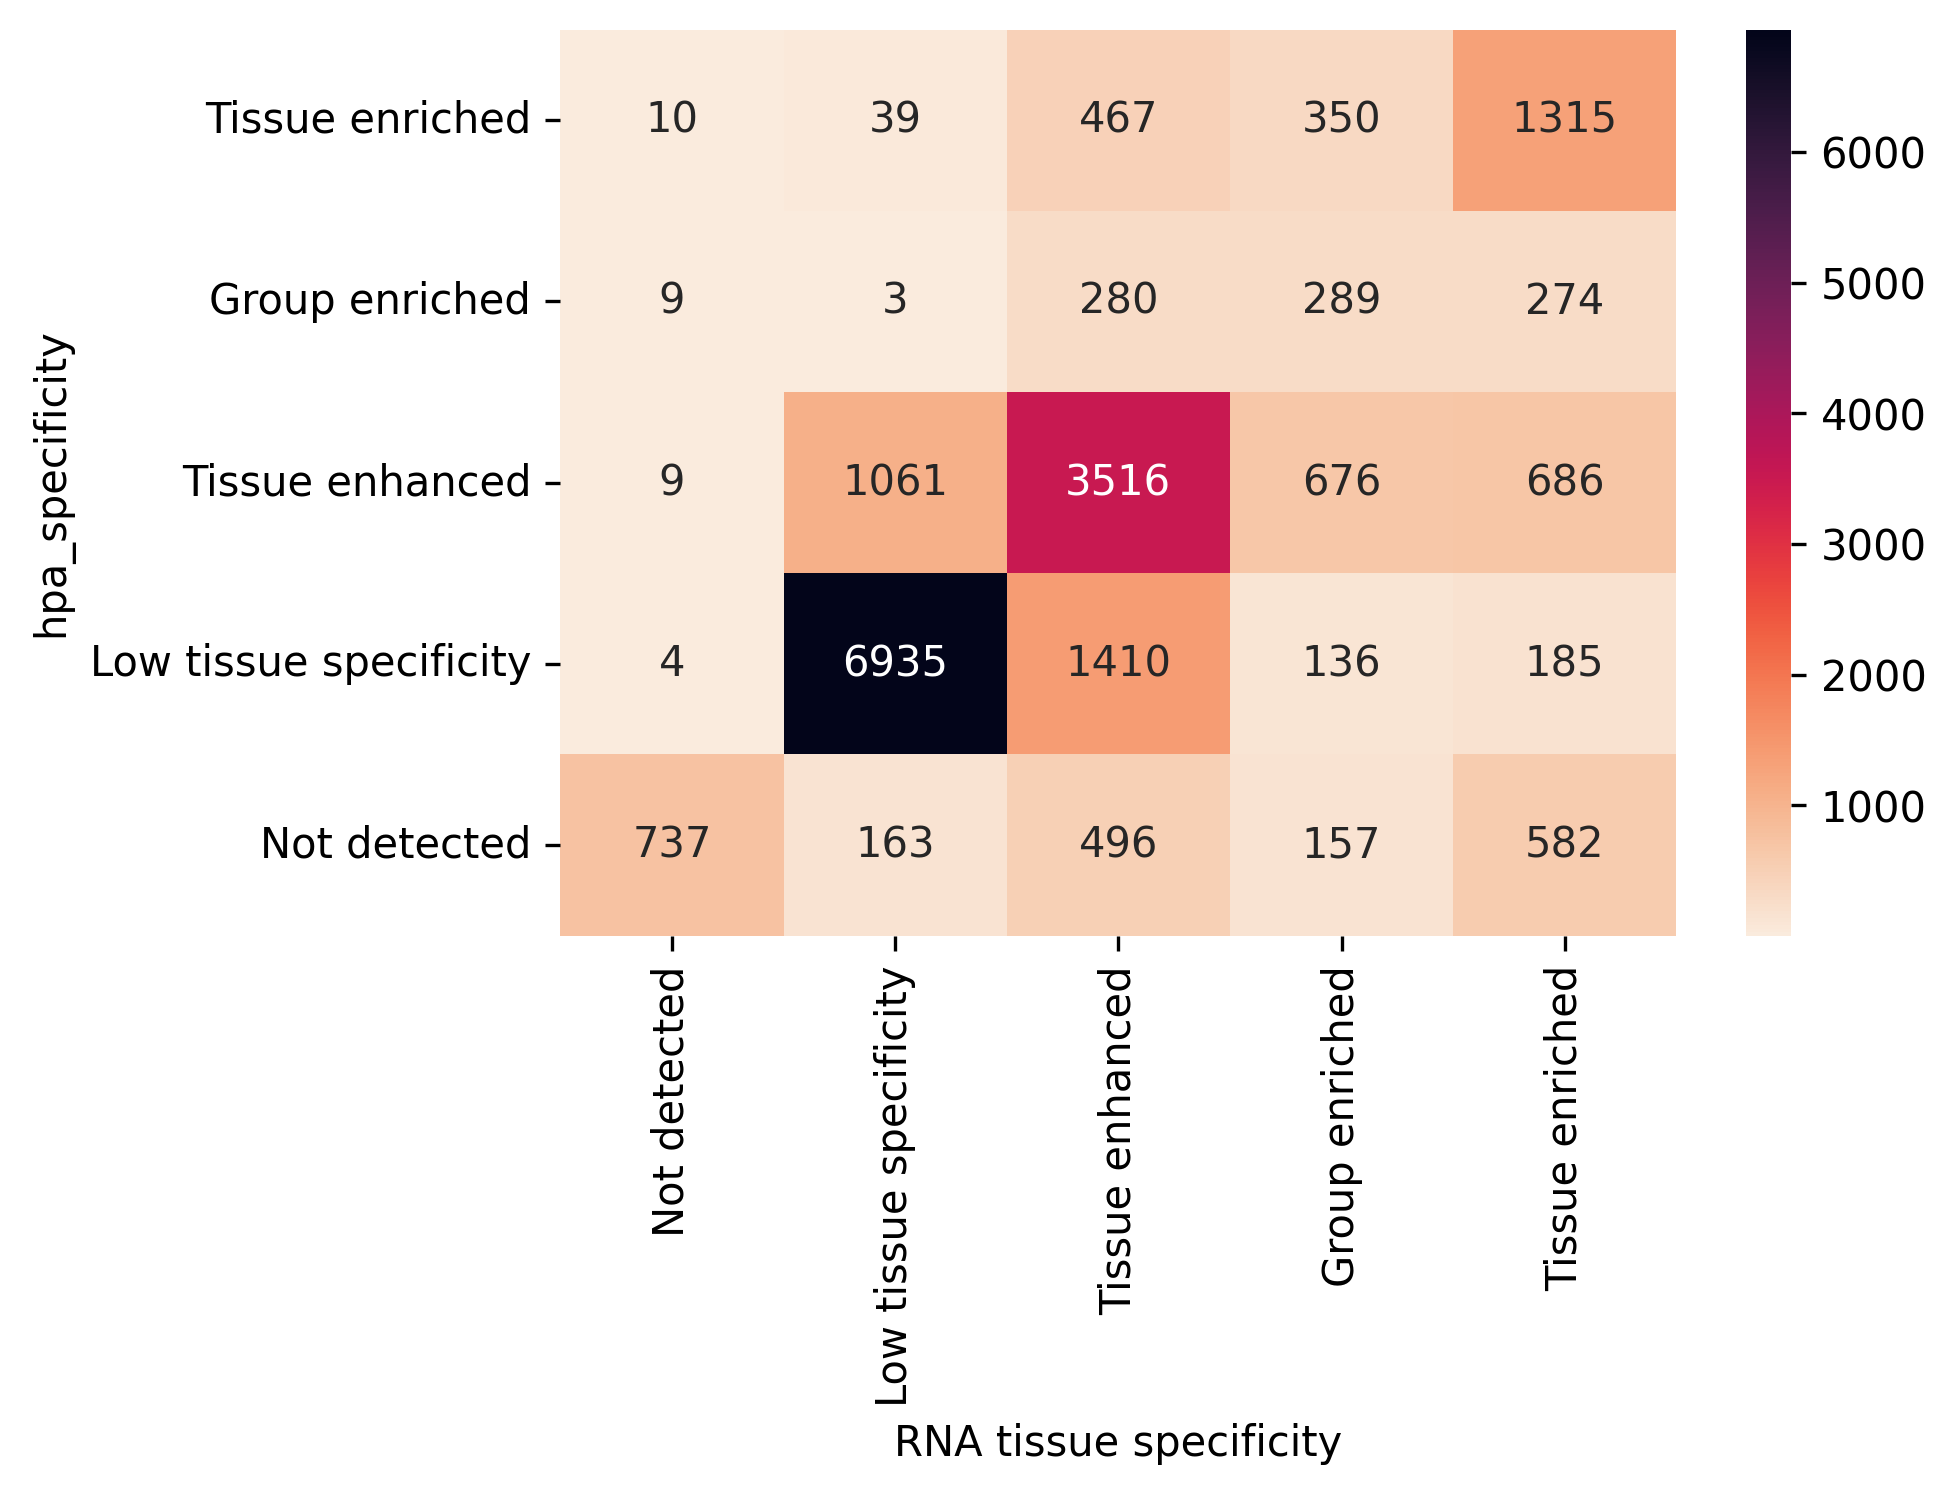

In [41]:
order = ['Not detected', 'Low tissue specificity', 'Tissue enhanced', 'Group enriched', 'Tissue enriched']
cross = pd.crosstab(a_merged.hpa_specificity, a_merged['RNA tissue specificity'])
cross = cross.reindex(order, axis='columns')
cross = cross.reindex(order[::-1], axis='rows')
sns.heatmap(cross, cmap='rocket_r', annot=True, fmt='g')

### 7.5.2. Distribution similarity matrix

<AxesSubplot:xlabel='RNA tissue distribution', ylabel='hpa_distribution'>

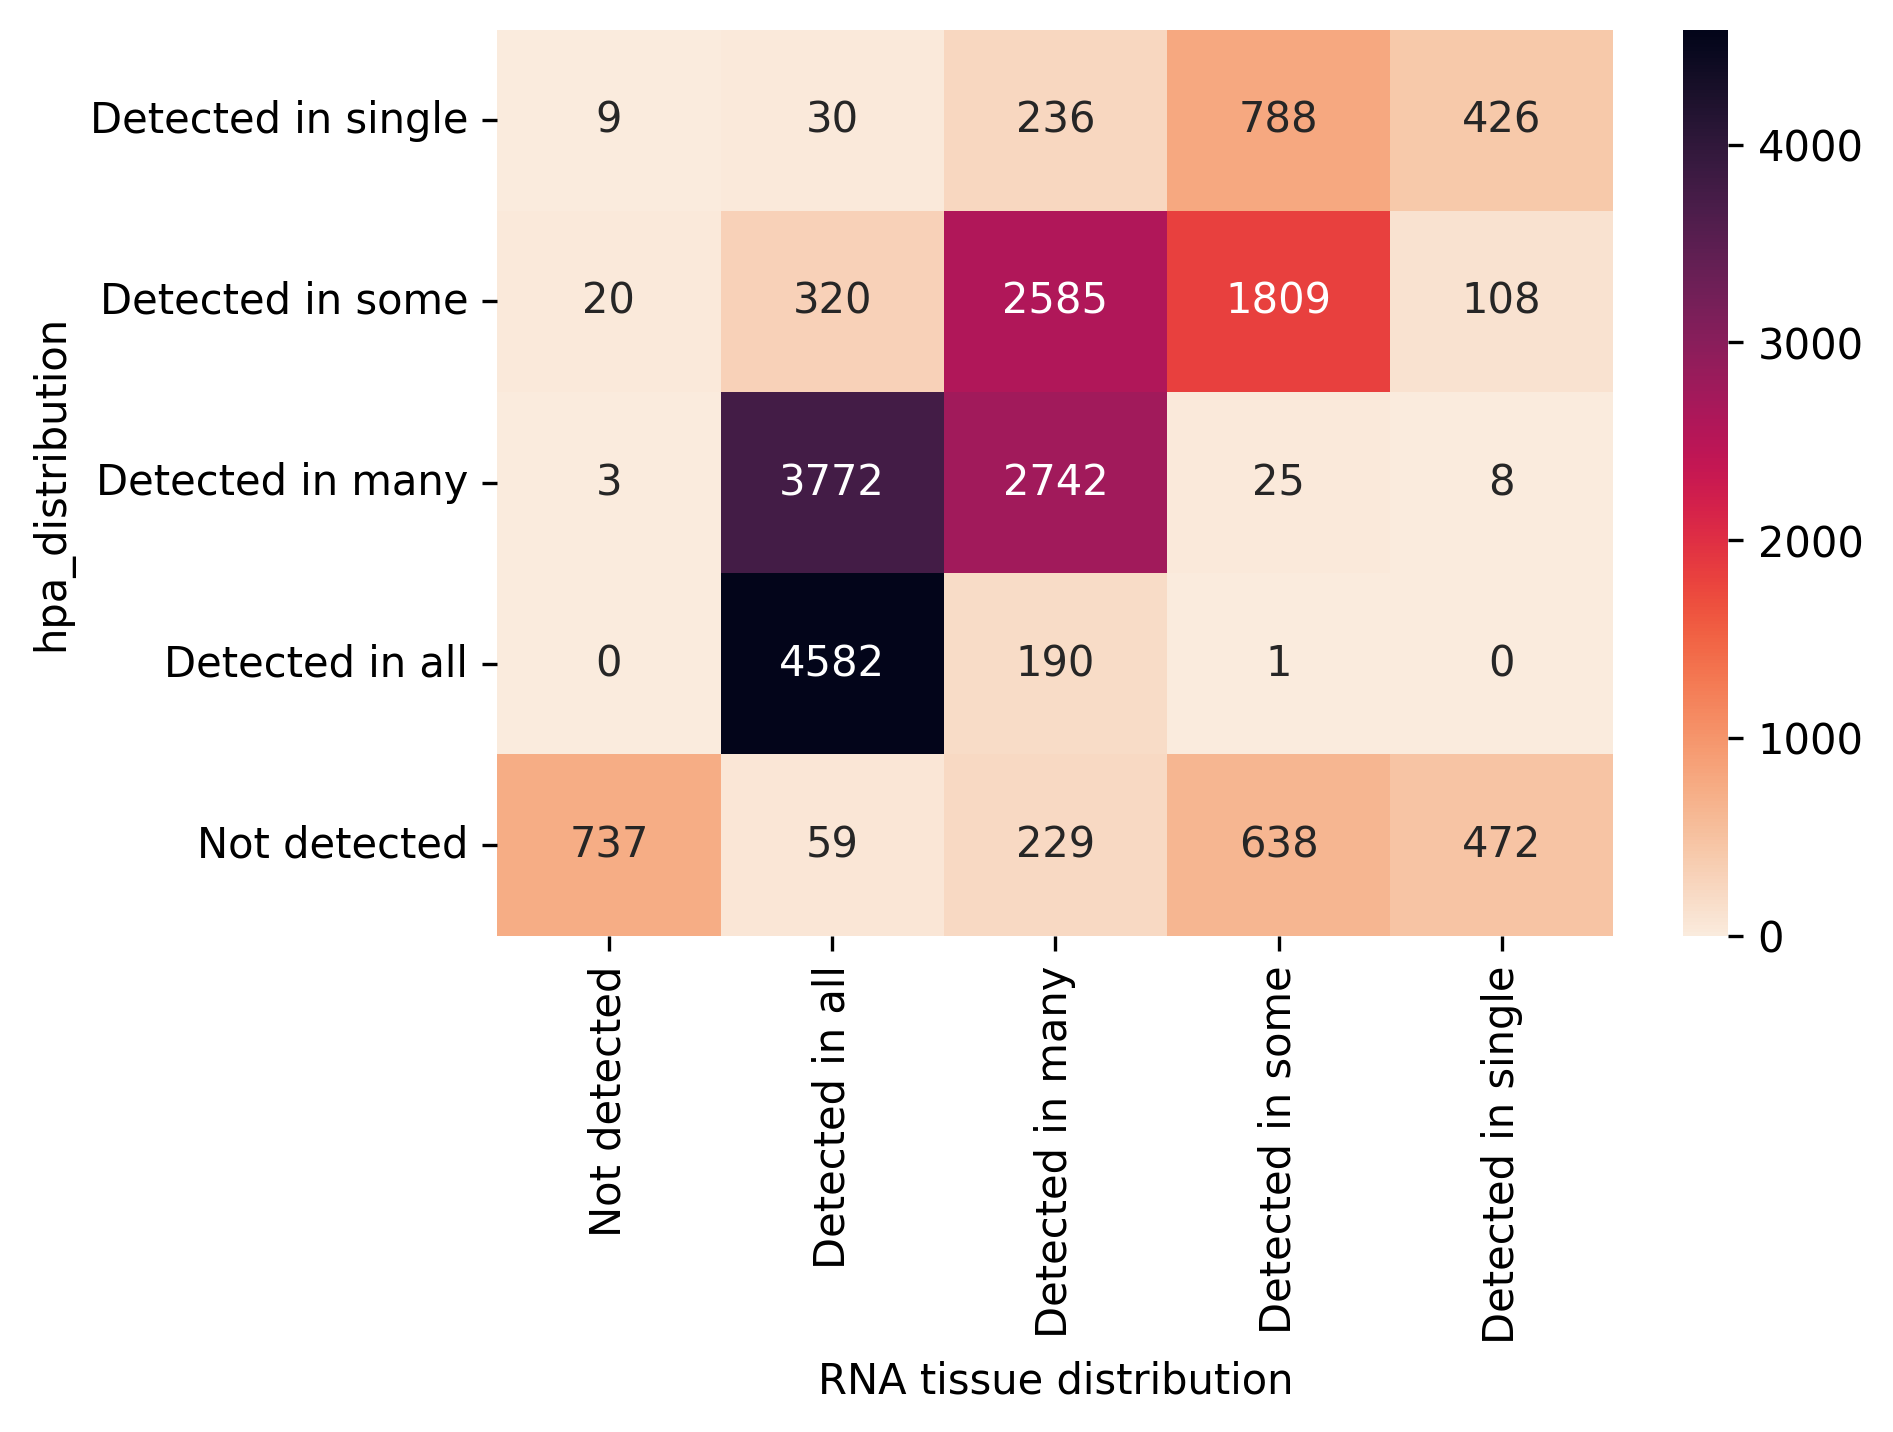

In [42]:
order = ['Not detected', 'Detected in all', 'Detected in many', 'Detected in some', 'Detected in single']
cross = pd.crosstab(a_merged.hpa_distribution, a_merged['RNA tissue distribution'])
cross = cross.reindex(order, axis='columns')
cross = cross.reindex(order[::-1], axis='rows')
sns.heatmap(cross, cmap='rocket_r', annot=True, fmt='g')

# 8. Process the data for output

## 8.1. Apply expression filters

As per HPA guidelines, we are filtering out the genes where the expression in all tissues is less than 1 TPM:

In [43]:
max_expression = d.max(axis=1)
expression_1tpm_filter = max_expression >= 1.0
d[expression_1tpm_filter]

,g1,g10,g11,g12,g13,g14,g15,g16,g17,g18,...,g49,g5,g50,g51,g52,g53,g6,g7,g8,g9
geneProductId,,,,,,,,,,,,,,,,,,,,,
ENSG00000001561,6.0,6.0,6.0,5.0,5.0,5.0,11.0,4.0,2.0,4.0,...,1.0,4.0,5.0,4.0,2.0,1.0,5.0,9.0,6.0,0.9
ENSG00000004142,34.0,37.0,27.0,32.0,35.0,41.0,34.0,57.0,33.0,31.0,...,45.0,92.0,36.0,31.0,32.0,34.0,25.0,32.0,43.0,16.0
ENSG00000004766,3.0,3.0,2.0,5.0,5.0,3.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,0.5
ENSG00000004948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000005073,0.0,0.2,0.0,0.0,0.0,0.0,0.0,1.0,17.0,28.0,...,6.0,0.3,6.0,9.0,40.0,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281523,1.0,0.0,0.7,11.0,13.0,2.0,0.0,0.2,0.4,1.0,...,0.0,0.0,0.0,0.0,3.0,0.3,0.9,0.0,0.0,0.0
ENSG00000281531,1.0,1.0,0.9,2.0,2.0,1.0,0.8,0.8,2.0,1.0,...,0.7,0.8,0.9,1.0,1.0,1.0,0.8,0.9,0.6,0.5
ENSG00000281548,0.2,0.4,0.2,0.4,0.4,0.2,0.2,0.2,0.3,0.4,...,0.3,0.3,0.3,0.2,0.3,0.3,0.2,0.2,0.2,0.2


## 8.2. Map tissue names

In [44]:
%%bash
. bash_functions.sh
extract_tissues metadata/E-MTAB-5214/E-MTAB-5214.metadata.json | tr '|' '\t' | cut -f2,3 > gtex_map.tsv

In [45]:
gtex_column_map = dict([line.split('\t') for line in open('gtex_map.tsv').read().splitlines()])
d_out = (
    d
    .rename(columns=gtex_column_map)
    [expression_1tpm_filter]
)
d_out

,Brodmann (1909) area 24,breast,caudate nucleus,cerebellar hemisphere,cerebellum,cerebral cortex,coronary artery,cortex of kidney,ectocervix,endocervix,...,transformed skin fibroblast,adrenal gland,transverse colon,urinary bladder,uterus,vagina,amygdala,aorta,atrium auricular region,blood
geneProductId,,,,,,,,,,,,,,,,,,,,,
ENSG00000001561,6.0,6.0,6.0,5.0,5.0,5.0,11.0,4.0,2.0,4.0,...,1.0,4.0,5.0,4.0,2.0,1.0,5.0,9.0,6.0,0.9
ENSG00000004142,34.0,37.0,27.0,32.0,35.0,41.0,34.0,57.0,33.0,31.0,...,45.0,92.0,36.0,31.0,32.0,34.0,25.0,32.0,43.0,16.0
ENSG00000004766,3.0,3.0,2.0,5.0,5.0,3.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,0.5
ENSG00000004948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000005073,0.0,0.2,0.0,0.0,0.0,0.0,0.0,1.0,17.0,28.0,...,6.0,0.3,6.0,9.0,40.0,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281523,1.0,0.0,0.7,11.0,13.0,2.0,0.0,0.2,0.4,1.0,...,0.0,0.0,0.0,0.0,3.0,0.3,0.9,0.0,0.0,0.0
ENSG00000281531,1.0,1.0,0.9,2.0,2.0,1.0,0.8,0.8,2.0,1.0,...,0.7,0.8,0.9,1.0,1.0,1.0,0.8,0.9,0.6,0.5
ENSG00000281548,0.2,0.4,0.2,0.4,0.4,0.2,0.2,0.2,0.3,0.4,...,0.3,0.3,0.3,0.2,0.3,0.3,0.2,0.2,0.2,0.2


## 8.3. Add UBERON IDs
Note: data from Expression Atlas doesn't include UBERON identifiers for GTEx data, so we have to add it manually from UBERON.

In [46]:
uberon = pronto.Ontology("http://purl.obolibrary.org/obo/uberon/ext.owl")

In [47]:
name_mapping = {}
for term in uberon.terms():
    if not term.name:
        continue
    name_mapping[term.name] = term.id
    for syn in term.synonyms:
        if syn.scope == "EXACT":
            name_mapping[syn.description] = term.id

Some tissue names from GTEx are not present in UBERON (under either exact or synonymous name), and have to be processed manually.

In [48]:
name_mapping['EBV-transformed lymphocyte'] = 'CL:0000945'  # lymphocyte of B lineage
name_mapping['transformed skin fibroblast'] = 'CL:0002620'  # skin fibroblast

## 8.4. Map annotation names

In [49]:
annotation_column_map = {
    'gini': 'gini', 
    'hpa_specificity': 'hpaSpecificity',
    'hpa_distribution': 'hpaDistribution'
}
columns_to_filter = list(annotation_column_map.keys())
a_out = (
    a
    [columns_to_filter]
    .rename(columns=annotation_column_map)
    [expression_1tpm_filter]
)
a_out['gini'] = a_out['gini'].round(3)
a_out

,gini,hpaSpecificity,hpaDistribution
geneProductId,,,
ENSG00000001561,0.299,Low tissue specificity,Detected in many
ENSG00000004142,0.174,Low tissue specificity,Detected in all
ENSG00000004766,0.169,Low tissue specificity,Detected in many
ENSG00000004948,0.947,Tissue enriched,Detected in single
ENSG00000005073,0.861,Tissue enhanced,Detected in some
...,...,...,...
ENSG00000281523,0.792,Tissue enhanced,Detected in some
ENSG00000281531,0.163,Low tissue specificity,Detected in some
ENSG00000281548,0.298,Tissue enriched,Detected in single


# 9. Calculate AdaTiSS scores
[Link to paper](https://academic.oup.com/bioinformatics/article/37/23/4469/6306407)

## 9.1. Export the data and prepare for run

In [50]:
d[expression_1tpm_filter].to_csv("adatiss_input.csv", index=True)

In [51]:
with open('adatiss_sample_phenotype.csv', 'w') as outfile:
    outfile.write('sample_ID,tissue\n')
    for sample, tissue in gtex_column_map.items():
        outfile.write(f'{sample},{tissue}\n')

In [52]:
! rm -rf AdaTiSS && git clone -q https://github.com/mwgrassgreen/AdaTiSS
# Hot fix for the mathematical bug in AdaTiSS
! sed -i 's/if (length(y\.1) >= 20)/if (length(y.1) >= 20 \&\& length(unique(y.1)) > 1)/g' AdaTiSS/R/AdaTiSS_fn.R

## 9.2. Process with AdaTiSS

In [53]:
%%R
source('./AdaTiSS/R/AdaTiSS_fn.R')
dat.rna = read.csv(file='./adatiss_input.csv', row.names=1)
X = preproc.filter.fn(dat.rna, dat.type = "TPM or RPKM", proc.zero = 'ceiled to 1', filter.col.prp = 1, exp.thres = 1)
p.dat = read.csv('adatiss_sample_phenotype.csv')
tiss.abd = tiss.abd.fn(X, p.dat)
result = AdaTiSS(X, tiss.abd=tiss.abd, adjust=TRUE, adjust.opt=0)
write.table(result$ada.s, file = "adatiss_output.tsv", sep = "\t", quote = FALSE, row.names = TRUE)

[1] 500
[1] 1000
[1] 1500
[1] 2000
[1] 2500
[1] 3000
[1] 3500
[1] 4000
[1] 4500
[1] 5000
[1] 5500
[1] 6000
[1] 6500
[1] 7000
[1] 7500
[1] 8000
[1] 8500
[1] 9000
[1] 9500
[1] 10000
[1] 10500
[1] 11000
[1] 11500
[1] 12000
[1] 12500
[1] 13000
[1] 13500
[1] 14000
[1] 14500
[1] 15000
[1] 15500
[1] 16000
[1] 16500
[1] 17000
[1] 17500
[1] 18000
[1] 18500
[1] 19000
[1] 19500
[1] 20000
[1] 20500
[1] 21000
[1] 21500
[1] 22000
[1] 22500
[1] 23000
[1] 23500
[1] 24000
[1] 24500
[1] 25000
[1] 25500


## 9.3. Read the results

In [54]:
adatiss = (
    # Read Adatiss output
    pd.read_table("adatiss_output.tsv")
    # Map from "g11" to "caudate nucleus" based on GTEx metadata
    .rename(columns=gtex_column_map)
)
adatiss.head()

,Brodmann (1909) area 24,breast,caudate nucleus,cerebellar hemisphere,cerebellum,cerebral cortex,coronary artery,cortex of kidney,ectocervix,endocervix,...,transformed skin fibroblast,adrenal gland,transverse colon,urinary bladder,uterus,vagina,amygdala,aorta,atrium auricular region,blood
ENSG00000001561,0.122923,0.122923,0.122923,-0.464703,-0.464703,-0.464703,2.076508,-1.183898,-3.417923,-1.183898,...,-5.651947,-1.183898,-0.464703,-1.183898,-3.417923,-5.651947,-0.464703,1.429743,0.122923,-5.651947
ENSG00000004142,-0.027849,0.400274,-1.195017,-0.334799,0.118918,0.920024,-0.027849,2.588215,-0.178998,-0.495546,...,1.391351,5.012116,0.261550,-0.495546,-0.334799,-0.027849,-1.584679,-0.334799,1.161170,-3.844282
ENSG00000004766,0.713414,0.713414,-0.892283,2.736352,2.736352,0.713414,-0.892283,-0.892283,-0.892283,-0.892283,...,-0.892283,0.713414,0.713414,-0.892283,0.713414,0.713414,-0.892283,-0.892283,-3.637239,-3.637239
ENSG00000004948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000005073,-0.503866,-0.503866,-0.503866,-0.503866,-0.503866,-0.503866,-0.503866,-0.503866,2.396622,2.907462,...,1.330439,-0.503866,1.330439,1.745532,3.272606,1.330439,-0.503866,-0.503866,-0.503866,-0.503866


## 9.4. Pack the results for output

In [55]:
def pack_adatiss_row(row):
    """Given a row with Adatiss results for a given gene, pack them into the list of (tissue, z-score) values ready for output."""
    # Extract the column names and values from the row
    cols = adatiss.columns
    vals = row.values.tolist()

    # Pack the values into a list of dictionaries
    dicts = []
    for col, val in zip(cols, vals):
        dicts.append({"bodyPartLevel": "tissue", "bodyPartName": col, "bodyPartId": name_mapping[col], "adatissScore": round(val, 3)})

    return dicts

In [56]:
a_out['adatissScores'] = adatiss.apply(pack_adatiss_row, axis=1)

In [57]:
a_out

,gini,hpaSpecificity,hpaDistribution,adatissScores
geneProductId,,,,
ENSG00000001561,0.299,Low tissue specificity,Detected in many,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
ENSG00000004142,0.174,Low tissue specificity,Detected in all,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
ENSG00000004766,0.169,Low tissue specificity,Detected in many,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
ENSG00000004948,0.947,Tissue enriched,Detected in single,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
ENSG00000005073,0.861,Tissue enhanced,Detected in some,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
...,...,...,...,...
ENSG00000281523,0.792,Tissue enhanced,Detected in some,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
ENSG00000281531,0.163,Low tissue specificity,Detected in some,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."
ENSG00000281548,0.298,Tissue enriched,Detected in single,"[{'bodyPartLevel': 'tissue', 'bodyPartName': '..."


# 10. Produce the final output

In [58]:
# Create a list to store JSON objects
json_list = []

# Iterate over each row index
for idx in d_out.index:
    # Create a dictionary for the current row
    row_dict = {
        "ensemblGeneId": idx,
        "expression": [
            {
                "bodyPartLevel": "tissue",
                "bodyPartId": name_mapping[key],
                "bodyPartName": key,
                "fpkm": value,
            }
            for key, value
            in d_out.loc[idx].to_dict().items()
        ],
        "expressionSpecificity": a_out.loc[idx].to_dict()
    }
    # Append the dictionary to the list
    json_list.append(row_dict)

print(json.dumps(json_list[0]))

{"ensemblGeneId": "ENSG00000001561", "expression": [{"bodyPartLevel": "tissue", "bodyPartId": "UBERON:0006101", "bodyPartName": "Brodmann (1909) area 24", "fpkm": 6.0}, {"bodyPartLevel": "tissue", "bodyPartId": "UBERON:0000310", "bodyPartName": "breast", "fpkm": 6.0}, {"bodyPartLevel": "tissue", "bodyPartId": "UBERON:0001873", "bodyPartName": "caudate nucleus", "fpkm": 6.0}, {"bodyPartLevel": "tissue", "bodyPartId": "UBERON:0002245", "bodyPartName": "cerebellar hemisphere", "fpkm": 5.0}, {"bodyPartLevel": "tissue", "bodyPartId": "UBERON:0002037", "bodyPartName": "cerebellum", "fpkm": 5.0}, {"bodyPartLevel": "tissue", "bodyPartId": "UBERON:0000956", "bodyPartName": "cerebral cortex", "fpkm": 5.0}, {"bodyPartLevel": "tissue", "bodyPartId": "UBERON:0001621", "bodyPartName": "coronary artery", "fpkm": 11.0}, {"bodyPartLevel": "tissue", "bodyPartId": "UBERON:0001225", "bodyPartName": "cortex of kidney", "fpkm": 4.0}, {"bodyPartLevel": "tissue", "bodyPartId": "UBERON:0012249", "bodyPartName"

In [59]:
with gzip.open("expression_v2.jsonl.gz", "wt", compresslevel=9) as f:
    for obj in json_list:
        f.write(json.dumps(obj))
        f.write('\n')

# Addendum. Index of all potential improvements

## Technical improvements and checks
* More comprehensive look into all metadata fields for identfying tissues and cell types
* 329 assays have no tissue information at all — HCA was working on it
* Some terms inconsistently have/have not ontology information attached, despite having the exact same name — HCA was working on it

## Process expression variation
We only use q2 (median expression) now. Instead of that, we could:
* Somehow take into account all distribution quartiles;
* Or, better yet, use data which was not aggregated by sample at all.

We could also look in more depth into FPKM vs TPM for comparing expression values.

## Improve tissue granularity
So far, we've looked at tissues as individual entities in a flat list, or, at most, as a two-level structure (major organ / tissue). If we can take into account the full complexity of tissue hierarchy, we could detect more interesting/nuanced cases of specificity of expression.

## Add more datasets
We are only using GTEx now. We can:
* Use a newer version of GTEx — supposedly HCA is working on that.
* Include more experiments, up to all available. This would require batch correction — supposedly HCA is working on that.

## Handle data sparseness and propagation
This is where data is available for not all tissues/not all levels of their organisation. We would also need to learn to propagate the expression information.

## Add single cell data
This would be super exciting, but would exacerbate all of the problems listed above in terms of complexity of the data and how to handle it.

## Add non-human data
This could lead to some interesting comparisons, including in application to translational research.

## Discuss the scope of the problem and how the output should look like
This is a general meta discussion point, in relation to the visualising the data on the Platform, as well as in the Target Engine.

## Additional data sources to evaluate
* Human Reference Atlas
* Genotype-Tissue Expression project
* (From the Adatiss paper) Other gene expression databases include the Tissue-specific Gene Expression and Regulation (TiGER) (Liu et al., 2008), the Human Protein Atlas portal (HPA) (Uhlén et al., 2015) and the Tissue-specific Gene DataBase in cancer (TissGDB) (Kim et al., 2018).

## Additional papers
* A benchmark of gene expression tissue-specificity metrics https://doi.org/10.1093/bib/bbw008